# Projeto - Questao 02

### Avaliação da Disciplina

<b>Julio Cesar Gonçalves Sales</b>

<b>Victor Medeiros Outtes Alves</b>

<b>Disciplina:</b> Computação Evolucionária e Inteligência de Enxames

![image.png](img/q2.png)

In [ ]:
import operator
import math
import random
import matplotlib.pyplot as plt
import pandas as pd

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from mpl_toolkits.mplot3d import Axes3D

#### Definições

In [2]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.uniform(-200,200))
pset.renameArguments(ARG0='x')
pset.renameArguments(ARG1='y')

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [4]:
def evalSymbReg(individual, input_points_x, input_points_y, output_points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    sqerrors = []
    
    tamanho = len(input_points_x)
    
    for i in range(tamanho):
        sqerrors.append((func(input_points_x[i], input_points_y[i]) - output_points[i])**2)
        
    return math.fsum(sqerrors) / tamanho,

#### A base utilizada foi a [Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

Esta base contém as medições de um dispositivo multissensor a gás implantado no campo em uma cidade italiana. Selecionamos como parâmetros da função de regressão que tentamos estimar os atributos RH (humidade relativa) e T (temperatura), e como resultado da função de regressão o atributo AH (humidade absoluta).

In [5]:
dados = pd.read_csv('AirQualityUCI.csv', usecols=[12,13,14], sep=';', decimal=',')

In [6]:
dados.head()

T    RH      AH
0  13.6  48.9  0.7578
1  13.3  47.7  0.7255
2  11.9  54.0  0.7502
3  11.0  60.0  0.7867
4  11.2  59.6  0.7888

In [7]:
input_points_x = list(dados.values[:,1])
input_points_y = list(dados.values[:,0])
output_points = list(dados.values[:,2])

In [8]:
toolbox.register("evaluate", evalSymbReg, input_points_x=input_points_x, input_points_y=input_points_y, output_points=output_points)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

In [9]:
def main():
    random.seed(318)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, 0.75, 0.5, 100, stats=mstats,
                                   halloffame=hof, verbose=False)
    
    return pop, log, hof

#### Plota a função original de acordo com os atributos utilizados da base e a função candidata

In [10]:
def plot(candidate_function):        
              
        candidate_points = []
        
        for i in range(len(input_points_x)):
            candidate_points.append(candidate_function(input_points_x[i], input_points_y[i]))    
                
        fig1 = plt.figure()
        ax1 = fig1.gca(projection='3d')
        ax1.plot(input_points_x, input_points_y, output_points, color='b')
        ax1.set_xlabel('RH')
        ax1.set_ylabel('T')
        ax1.set_zlabel('AH')
        ax1.set_title('Função original')
        
        fig2 = plt.figure()
        ax2 = fig2.gca(projection='3d')
        ax2.plot(input_points_x, input_points_y, candidate_points, color='r') 
        ax2.set_xlabel('RH')
        ax2.set_ylabel('T')
        ax2.set_zlabel('AH')       
        ax2.set_title('Função candidata')
        
        plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
<string>:1: RuntimeWarning: invalid value encountered in double_scalars


Função encontrada: protectedDiv(protectedDiv(mul(-35.393975705666236, -5.473475568809363), protectedDiv(protectedDiv(neg(-173.66383503258388), y), y)), -183.547734338767)


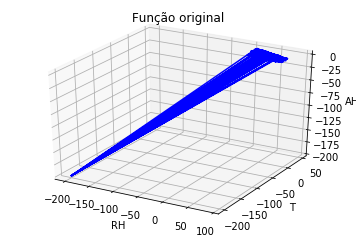

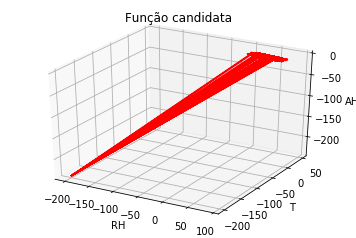

In [11]:
if __name__ == "__main__":
    results = main()
    
    expr = results[2][0]
    
    print('Função encontrada: ' + str(expr))
    
    
    '''PLOTANDO OS GRAFICOS'''
    tree = gp.PrimitiveTree(expr)
    
    candidate_function = toolbox.compile(tree)
    
    
    
    plot(candidate_function)